# Image decompression and azimuthal integration on the GPU

This tutorial explains how it is possible to speed-up azimuthal integration by speeding-up the critical part: the data transfer to the GPU.

For this tutorial, very recent version of `silx` and `pyFAI` are needed, newer than fall 2022.

**Credits:**

* Thomas Vincent (ESRF) for the HDF5 direct chunk read and the Jupyter-slurm
* Jon Wright (ESRF) for the initial prototype of the bitshuffle-LZ4 decompression on the GPU
* Pierre Paleo (ESRF) for struggling with this kind of stuff with GPUs

**Nota:** a (fast) GPU is needed for this tutorial with OpenCL properly setup !

The example taken here is the same as the multithreading example: 4096 frames of Eiger_4M in one file to be decompressed and integrated.

In [1]:
%matplotlib inline

In [4]:
import sys, os, collections, struct, time
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
import numpy, pyFAI
import h5py, hdf5plugin
from matplotlib.pyplot import subplots
import bitshuffle
import pyopencl.array as cla
import silx
from silx.opencl import ocl
from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4
print("Silx version: ", silx.version)
print("pyFAI version: ", pyFAI.version)
start_time = time.time()
ocl

Silx version:  1.2.0-a0
pyFAI version:  0.22.0-dev11


OpenCL devices:
[0] NVIDIA CUDA: (0,0) NVIDIA GeForce RTX 3080

In [5]:
#Here we select the OpenCL device
target = (0,0)
device = ocl.platforms[target[0]].devices[target[1]]
print("Working on device:", device)

Working on device: NVIDIA GeForce RTX 3080


## Setup the enviroment:

This is a purely virtual experiment, we will use an Eiger 4M detector with data integrated over 1000 bins. Those parameters can be tuned.

Random data are generated, to keep this file fairly small, it is generated with small numbers which compress nicely. The speed of the drive where you will put the file is likely to have a huge impact !

In [6]:
det = pyFAI.detector_factory("eiger_4M")
shape = det.shape
dtype = numpy.dtype("uint32")
filename = "/tmp/big.h5"
nbins = 1000
cmp = hdf5plugin.Bitshuffle()
hdf5plugin.config

HDF5PluginBuildOptions(openmp=False, native=False, sse2=True, avx2=False, cpp11=True, filter_file_extension='.so', embedded_filters=('blosc', 'bshuf', 'fcidecomp', 'lz4', 'zfp', 'zstd'))

In [7]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
print(f"Number of frames the computer can host in memory: {mem_bytes/(numpy.prod(shape)*dtype.itemsize):.3f}")
if os.environ.get('SLURM_MEM_PER_NODE'):
    print(f"Number of frames the computer can host in memory with SLURM restrictions: {int(os.environ['SLURM_MEM_PER_NODE'])*(1<<20)/(numpy.prod(shape)*dtype.itemsize):.3f}")

Number of frames the computer can host in memory: 1869.978


In [8]:
#The computer being limited to 64G of RAM, the number of frames actually possible is 3800.
nbframes = 4096 # slightly larger than the maximum achievable ! Such a dataset should not host in memory.

In [9]:
#Prepare a frame with little count so that it compresses well
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
omega = ai.solidAngleArray()
q = numpy.arange(15)
img = ai.calcfrom1d(q, 100/(1+q*q))
frame = numpy.random.poisson(img).astype(dtype)

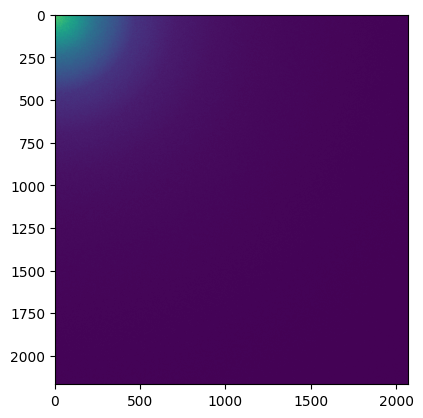

In [10]:
# display the image
fig,ax = subplots()
ax.imshow(frame)
pass

In [11]:
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU")
for algo in ("histogram", "csc", "csr"):
    print(f"Using algorithm {algo:10s}:", end=" ")
    %timeit ai.integrate1d(frame, nbins, method=("full", algo, "cython"))
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU: ", device)
print(f"Using algorithm {algo:10s}:", end=" ")
timing_integration = %timeit -o ai.integrate1d(frame, nbins, method=("full", algo, "opencl", target))

Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU
Using algorithm histogram : 599 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csc       : 38.9 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csr       : 44.5 ms ± 6.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU:  NVIDIA GeForce RTX 3080
Using algorithm csr       : 2.31 ms ± 64.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Note:** The full pixel splitting is time consuming and handicaps the histogram algorithm while both sparse-matrix methods are much faster since they cache this calculation in the sparse matrix.

On the AMD Threadripper, the serial CSC algorithm is faster than the parallel CSR algorithm. This is due to the lage L3 cache.
This differs from the Intel Xeon processor where the parallel CSR algorithm is faster than the serial CSC algorithm (as expected).

In [12]:
# How is the time spend when integrating on GPU (with default parameters) ?
res0 = ai.integrate1d(frame, nbins, method=("full", "csr", "opencl", target))
engine = ai.engines[res0.method].engine
engine.reset_log()
engine.set_profiling(True)
omega_crc = engine.on_device["solidangle"]
%timeit engine.integrate_ng(frame, solidangle=omega, solidangle_checksum=omega_crc)
print("\n".join(engine.log_profile(stats=True)))
engine.set_profiling(False)
engine.reset_log()

2.19 ms ± 2.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_CSR_Integrator
                                       Kernel name (count):      min   median      max     mean      std
                               copy raw H->D image (  811):    1.177    1.191    1.323    1.194    0.011
                              convert u32_to_float (  811):    0.054    0.056    0.072    0.056    0.001
                                         memset_ng (  811):    0.002    0.003    0.007    0.003    0.000
                                      corrections4 (  811):    0.161    0.163    0.193    0.163    0.002
                                    csr_integrate4 (  811):    0.356    0.358    0.703    0.363    0.027
                                  copy D->H avgint (  811):    0.001    0.001    0.002    0.001    0.000
                                     copy D->H std (  811):    0.001    0.001    0.002    0.001    0.000
            

**Note:** A large part of the time is spent in the transfer from the host to the device.

### Let's benchmark azimuthal integration without this transfer:

Just transfer the image to the GPU ... 

In [13]:
frame_d = cla.to_device(engine.queue, frame)
engine.set_profiling(True)
tai_before = %timeit -o engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
print("\n".join(engine.log_profile(stats=True)))
engine.set_profiling(False)
engine.reset_log()

875 µs ± 425 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_CSR_Integrator
                                       Kernel name (count):      min   median      max     mean      std
                               copy raw D->D image ( 8111):    0.055    0.056    0.062    0.057    0.001
                              convert u32_to_float ( 8111):    0.054    0.056    0.057    0.056    0.001
                                         memset_ng ( 8111):    0.003    0.003    0.004    0.003    0.000
                                      corrections4 ( 8111):    0.161    0.162    0.166    0.162    0.000
                                    csr_integrate4 ( 8111):    0.355    0.357    0.372    0.358    0.002
                                  copy D->H avgint ( 8111):    0.001    0.001    0.002    0.001    0.000
                                     copy D->H std ( 8111):    0.001    0.001    0.002    0.001    0.000
            

In [14]:
# Workgroup size ranges for the different kernels involved:
for k,v in engine.workgroup_size.items():
    print(k,v)

s8_to_float (32, 256)
u8_to_float (32, 256)
s16_to_float (32, 256)
u16_to_float (32, 256)
u32_to_float (32, 256)
s32_to_float (32, 256)
corrections (32, 256)
corrections2 (32, 256)
corrections3 (32, 256)
corrections4 (32, 256)
memset_out (32, 256)
memset_ng (32, 256)
memset1 (32, 256)
memset2 (32, 256)
memset4 (32, 256)
memset8 (32, 256)
memset_int (32, 256)
csr_integrate (32, 256)
csr_integrate_single (32, 256)
csr_integrate4 (32, 256)
csr_integrate4_single (32, 256)
csr_sigma_clip4 (32, 256)


In [15]:
# Profiling the engine with various workgroup sizes:
wg = 32
wg_max = device.max_work_group_size
res0 = ai.integrate1d(frame, nbins, method=("full", "csr", "opencl", target))
engine = ai.engines[res0.method].engine
omega_crc = engine.on_device["solidangle"]
engine.reset_log()
engine.set_profiling(True)
logs = {}
while wg<=wg_max:
    print(f"Workgroup_size: {wg:4d} ", end="")
    %timeit engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc, workgroup_size=wg)
    logs[wg] = engine.log_profile(stats=True)
    engine.reset_log()
    wg*=2

engine.set_profiling(False)

Workgroup_size:   32 890 µs ± 519 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup_size:   64 778 µs ± 537 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup_size:  128 776 µs ± 646 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup_size:  256 758 µs ± 891 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup_size:  512 724 µs ± 507 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup_size: 1024 718 µs ± 653 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
# Sort out the log results per kernel and per workgroup size:
one_wg = logs[32]
print("Kernel run-time (ms) as function of the workgroup size:              min   median      max     mean      std")
for kn in one_wg:
    if "):" in kn and kn[-1].isdigit():
        key = kn.split("(")[0]
        if "copy" in key:
            continue
        for wg,lg in logs.items():
            for l in lg:
                if key in l:
                    print(f"{wg:4d} {l}")
        print("-"*50)

Kernel run-time (ms) as function of the workgroup size:              min   median      max     mean      std
  32                               convert u32_to_float ( 8111):    0.089    0.090    0.101    0.091    0.002
  64                               convert u32_to_float ( 8111):    0.055    0.056    0.057    0.056    0.000
 128                               convert u32_to_float ( 8111):    0.054    0.055    0.057    0.056    0.001
 256                               convert u32_to_float ( 8111):    0.054    0.055    0.057    0.056    0.001
 512                               convert u32_to_float ( 8111):    0.054    0.055    0.059    0.056    0.001
1024                               convert u32_to_float ( 8111):    0.057    0.058    0.059    0.058    0.000
--------------------------------------------------
  32                                          memset_ng ( 8111):    0.002    0.003    0.004    0.003    0.000
  64                                          memset_ng ( 8111):    0.

**Note:** 

* A large fraction of the time is spent in the transfer from the CPU to the GPU.
* Different kernels see different minimum execution time depending on their structure. For this Nvidia GTX1080Ti GPU (Pascal) one observes:

  - simple conversion kernel works best with any large workgroup-size (128-256) 
  - *correction4* works best with any large workgroup-size (1024) 
  - CSR sparse matrix multiplication is best used with a larger workgroup size (1024)

Those results also vary from device to device and between drivers !

In [17]:
#tune the different workgroup sizes:
engine.workgroup_size["s32_to_float"] = (256, 256)
engine.workgroup_size["u8_to_float"] = (256, 256)
engine.workgroup_size["s16_to_float"] = (256, 256)
engine.workgroup_size["s8_to_float"] = (256, 256)
engine.workgroup_size["u32_to_float"] = (256, 256)
engine.workgroup_size["u16_to_float"] = (256, 256)
engine.workgroup_size["corrections4"] = (1024, 1024)
engine.workgroup_size["csr_integrate4"] = (1024, 1024)
tai_after = %timeit -o engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
print(f"Workgroup size optimization allowed to gain: {(tai_before.average-tai_after.average)/tai_before.average*100:.1f}%")

626 µs ± 541 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size optimization allowed to gain: 28.4%


## Preparation of some HDF5 file:

* with many frames in them, 
* compressed in Bitshuffle-LZ4,
* each chunk being one frame.

In [18]:
%%timeit -r1 -n1 -o -q
#Saving of a HDF5 file with many frames ...
with h5py.File(filename, "w") as h:
    ds = h.create_dataset("data", shape=(nbframes,)+shape, chunks=(1,)+shape, dtype=dtype, **cmp) 
    for i in range(nbframes):
        ds[i] = frame + i%500 #Each frame has a different value to prevent caching effects

<TimeitResult : 59.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [19]:
timing_write = _
size=os.stat(filename).st_size
print(f"File size {size/(1024**3):.3f} GB with a compression ratio of {nbframes*numpy.prod(shape)*dtype.itemsize/size:.3f}x")
print(f"Write speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_write.best):.3f} MB/s of uncompressed data, or {nbframes/timing_write.best:.3f} fps.")

File size 9.239 GB with a compression ratio of 7.409x
Write speed: 1240.448 MB/s of uncompressed data, or 69.134 fps.


In [20]:
%%timeit -r1 -n1 -o -q
#Reading all frames and decompressing them
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])

<TimeitResult : 42.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [21]:
timing_read1 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read1.best):.3f} MB/s of uncompressed data, or {nbframes/timing_read1.best:.3f} fps.")

Read speed: 1736.257 MB/s of uncompressed data, or 96.766 fps.


In [22]:
# Time for decompressing one frame:
chunk = bitshuffle.compress_lz4(frame,0)
print(f"Compression ratio: {frame.nbytes/len(chunk):.3f}x")
timing_decompress = %timeit -o bitshuffle.decompress_lz4(chunk, frame.shape, frame.dtype, 0)
print(f"Decompression speed: {1/timing_decompress.best:.3f} fps")

Compression ratio: 9.099x
9.53 ms ± 9.86 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Decompression speed: 104.996 fps


In [23]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

<TimeitResult : 1.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [24]:
timing_read2 = _
print(f"Read speed: {size/(1e6*timing_read2.best):.3f} MB/s of compressed data.")
print(f"HDF5 read speed (without decompression): {nbframes/timing_read2.best:.3f} fps.")

Read speed: 6093.731 MB/s of compressed data.
HDF5 read speed (without decompression): 2516.098 fps.


In [25]:
timimg_sum = timing_integration.best + timing_read2.best/nbframes+timing_decompress.best
print(f"The maximum throughput considering reading, decompression and integration is {1/timimg_sum:.3f} fps.")

The maximum throughput considering reading, decompression and integration is 82.152 fps.


**Summary:**

* Read speed: 2100 fps
* Read + decompress: 93 fps
* Read + decomperss + integrate: 55 fps.

## Decompression on the GPU

Decompression of the GPU has 3 main advantages:

* Transfer less data from the the host to the device since it is compressed
* Inflated data on the device remain on the device, thus 
* Most of the decompression algorithm is performed in parallel and exploits the GPU efficiently

There is one part of the decompression which remains serial, the part searching for the begining of each of the compressed blocks.

**Nota:** This feature requires silx 1.2 !

In [26]:
# Read one chunk
with h5py.File(filename, "r") as h:
    ds = h["data"]
    i=0
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

In [27]:
gpu_decompressor = BitshuffleLz4(len(chunk), frame.size, dtype=frame.dtype, ctx=engine.ctx)

In [28]:
#Tune the decompressor for the fastest speed:
wg = 32
wg_max = device.max_work_group_size
gpu_decompressor.set_profiling(True)
logs = {}
while wg<=wg_max:
    print(f"Workgroup size {wg:4d} : ", end=" ")
    %timeit gpu_decompressor.decompress(chunk, wg=wg); gpu_decompressor.queue.finish()
    logs[wg] = gpu_decompressor.log_profile(stats=True)
    gpu_decompressor.reset_log()
    wg*=2
    
gpu_decompressor.set_profiling(False)

Workgroup size   32 :  1.22 ms ± 643 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size   64 :  1.07 ms ± 129 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  128 :  998 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  256 :  988 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  512 :  1.02 ms ± 324 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 1024 :  1.19 ms ± 845 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
# Sort out the log results per workgroup size:
one_wg = logs[32]
print("Kernel run-time (ms) as function of the workgroup size:              min   median      max     mean      std")
for kn in one_wg:
    if "):" in kn and kn[-1].isdigit():
        key = kn.split("(")[0]
        if "copy" in key:
            continue
        for wg,lg in logs.items():
            for l in lg:
                if key in l:
                    print(f"{wg:4d} {l}")
        print("-"*50)

Kernel run-time (ms) as function of the workgroup size:              min   median      max     mean      std
  32                                        LZ4 unblock ( 8111):    0.579    0.581    0.807    0.584    0.010
  64                                        LZ4 unblock ( 8111):    0.577    0.580    0.642    0.582    0.005
 128                                        LZ4 unblock ( 8111):    0.577    0.580    0.642    0.582    0.005
 256                                        LZ4 unblock ( 8111):    0.579    0.582    0.645    0.584    0.005
 512                                        LZ4 unblock ( 8111):    0.564    0.568    0.642    0.570    0.005
1024                                        LZ4 unblock ( 8111):    0.555    0.557    0.642    0.559    0.005
--------------------------------------------------
  32                                     LZ4 decompress ( 8111):    0.414    0.417    1.066    0.418    0.011
  64                                     LZ4 decompress ( 8111):    0.

In [30]:
#Set the workgroup size (called block in cuda) to the best value we found previoulsy.
gpu_decompressor.block_size = 256 

**Note:** There is only one kernel (LZ4 decompress) which deserves having the workgroup size tuned, this is wy we set it globally.

## Assemble optimized OpenCL blocks and integrate all frames from a HDF5-file

In [31]:
#Build a pipeline with decompression and integration on the GPU:
%timeit engine.integrate_ng(gpu_decompressor(chunk), solidangle=omega, solidangle_checksum=omega_crc)

1.62 ms ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [32]:
result = numpy.empty((nbframes, nbins), dtype=numpy.float32)

In [33]:
%%timeit -r1 -n1 -o -q
# Process a complete stack:
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
        result[i] = engine.integrate_ng(gpu_decompressor(chunk), solidangle=omega, solidangle_checksum=omega_crc).intensity

<TimeitResult : 9.78 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [34]:
timing_process_gpu = _
print(f"Processing speed when decompression occures on GPU: {nbframes/timing_process_gpu.best:.3f} fps which represents at speed-up of {timimg_sum*nbframes/timing_process_gpu.best:.3f}x.")

Processing speed when decompression occures on GPU: 419.002 fps which represents at speed-up of 5.100x.


## Display some results
Since the input data were all synthetic and similar, no great science is expected from this... but one can ensure each frame differs slightly from the neighbors with a pattern of 500 frames. 

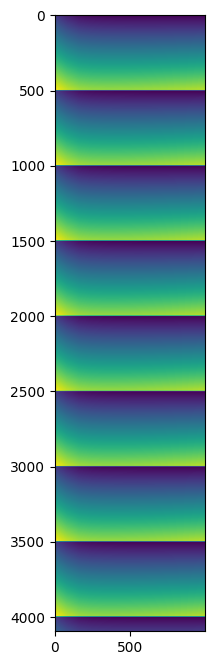

In [35]:
fig,ax = subplots(figsize=(8,8))
ax.imshow(result)

## Conclusion

Reading Bitshuffle-LZ4 data can be off-loaded to the GPU, this is especially appealing when downstream processing requires also GPU-computing llike azimuthal integration. 

The procedure is simpler than the multi-threading approach: no queue, no threads, ... but requires a GPU.

The performances obtained on a (not so recent Tesla V100) is similar to a much more recent 2x32-cores computer: ~500 fps

Those performances can be further parallelized using multiprocessing.

In [36]:
print(f"Total processing time: {time.time()-start_time:.3f} s")

Total processing time: 578.791 s
